(This post has been edited after Philippe Lonjoux's insightful comment. The amendments I made are highlighted in my answer to his comment.)


Hello there!

This notebook exploits the analysis I did [here][1] to boost the performance of a classifier.

In particular, I will show how additional features computed from 'manager_id' can substantially improve performances by building upon the neat ["Random Forest Starter"][2] by Li Li

  [1]: https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id
  [2]: https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features

In [1]:
# ...let's import the modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

/home/bolaik/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
# ... and load the training data
df = pd.read_json(open("../input/train.json", "r"))
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


### Naive feature engineering (from Li Li's Random Forest Starter)

In [62]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

### Basic encoding of 'manager_id', from SRK ["XGBoost starter"][1] 


  [1]: https://www.kaggle.com/sudalairajkumar/two-sigma-connect-rental-listing-inquiries/xgb-starter-in-python

In [63]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['manager_id'].values))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

# let's add this feature
features_to_use.append('manager_id')

### Let's now add 3 columns contaning the fractions of 'low','medium' and 'high' interest level obtained by each manager in the training dataset. 

### We also add the simple 'manager_skill' feature I introduced in my [previous notebook][1].

### We use mean values for those managers who don't have enough entries for being ranked (minimum = 20 here).


----------


### As pointed out by Philippe Lonjoux's, since these new features involve the target variable, we split the dataset first so to avoid "cheating" during the validation phase. The features are computed for each manager on the training part and the values obtained are then copied for the instances in the validation dataset. 


  [1]: https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id.

In [64]:
# Let's split the data
X = df[features_to_use]
y = df["interest_level"]
np.random.seed(3668)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [65]:
# compute fractions and count for each manager
temp = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
temp.tail(10)

,high_frac,low_frac,medium_frac,count
manager_id,,,,
3469,0.000000,0.500000,0.500000,2
3470,0.000000,0.000000,1.000000,1
3471,0.000000,0.666667,0.333333,3
3472,0.600000,0.400000,0.000000,5
3473,0.000000,1.000000,0.000000,1
3475,0.000000,0.750000,0.250000,4
3477,0.000000,1.000000,0.000000,7
3478,0.000000,1.000000,0.000000,1
3479,0.333333,0.666667,0.000000,3


In [66]:
# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']
temp.sort_values('count', ascending=False).head()

,high_frac,low_frac,medium_frac,count,manager_skill
manager_id,,,,,
3135,0.064988,0.685597,0.249415,1708,0.379391
1499,0.006397,0.899787,0.093817,469,0.106610
1954,0.000000,0.985663,0.014337,279,0.014337
1338,0.000000,1.000000,0.000000,272,0.000000
2784,0.152263,0.370370,0.477366,243,0.781893


In [67]:
# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
temp.tail(5)

high_frac        0.084078
low_frac         0.658227
medium_frac      0.257694
manager_skill    0.425851
dtype: float64


,high_frac,low_frac,medium_frac,count,manager_skill
manager_id,,,,,
3475,0.084078,0.658227,0.257694,4,0.425851
3477,0.084078,0.658227,0.257694,7,0.425851
3478,0.084078,0.658227,0.257694,1,0.425851
3479,0.084078,0.658227,0.257694,3,0.425851
3480,0.040541,0.662162,0.297297,74,0.378378


In [68]:
# left join to assign manager features to the managers in the training dataframe
X_train = X_train.merge(temp.reset_index(), how='left', left_on='manager_id', right_on='manager_id')
X_train.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,2.0,2,40.7518,-73.9726,5072,6,7,148,2016,5,30,710,0.084078,0.658227,0.257694,15,0.425851
1,1.0,2,40.6484,-74.0117,1800,0,0,48,2016,4,16,3135,0.064988,0.685597,0.249415,1708,0.379391
2,1.0,2,40.7063,-74.0108,3350,8,7,60,2016,6,20,1760,0.000000,1.000000,0.000000,21,0.000000
3,1.0,1,40.7341,-73.9896,3725,6,4,6,2016,5,25,1206,0.084078,0.658227,0.257694,11,0.425851
4,1.0,1,40.7287,-73.9838,2595,12,2,9,2016,6,26,3149,0.000000,1.000000,0.000000,27,0.000000


In [69]:
# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = X_val['high_frac'].isnull()
X_val.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
X_val.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,0,40.7034,-74.0114,2625,7,7,82,2016,5,18,2865,0.000000,0.750000,0.250000,32.0,0.250000
1,2.0,4,40.7413,-73.9781,6400,4,10,110,2016,4,23,1411,0.073529,0.455882,0.470588,68.0,0.617647
2,1.0,1,40.7277,-73.9832,2599,5,3,67,2016,6,20,1787,0.045455,0.590909,0.363636,22.0,0.454545
3,1.0,1,40.6899,-73.9941,4410,5,2,60,2016,4,18,1903,0.032680,0.967320,0.000000,153.0,0.065359
4,1.0,2,40.7242,-73.9824,2375,3,3,103,2016,6,23,1990,0.000000,1.000000,0.000000,25.0,0.000000


In [70]:
# add manager fractions and skills to the features to use
features_to_use.extend(['high_frac','low_frac', 'medium_frac','manager_skill'])

### Let's train and validate a few random forest classifiers to see whether we can improve performances with the additional features

### Basic model with no manager-related features, this is the model in Li Li's Random Forest Starter

In [71]:
# features to use for this classifier == only basic numerical
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62888516522015747

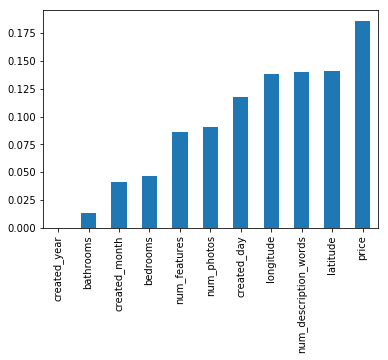

In [72]:
# Let's visualize features importance, 
# price is the most important feature, followed by number of descriptive words, latitude and longitude
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### Let's add manager_id and see if we can get some improvement already

In [73]:
# add manager_id
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62451862039469064

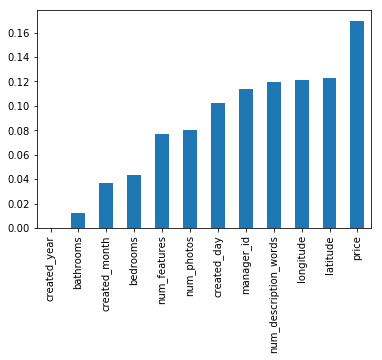

In [74]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### We get a small improvement, but we can do better. Let's remove 'manager_id' and use manager interest fractions and skill instead

In [75]:
# no manager_id, use fractions and skill instad
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['manager_id']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62159510404862672

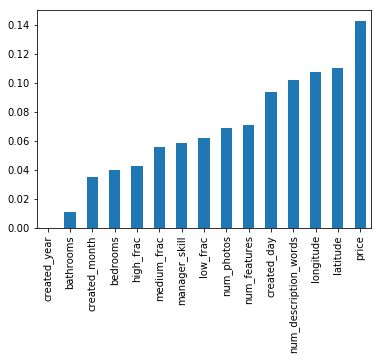

In [76]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### That's an improvement, but maybe we can do better if we just use the fractions.

In [77]:
# no manager_id, no skill, use fractions
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['manager_id','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.6151770881663976

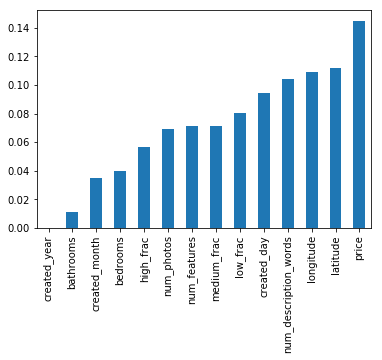

In [78]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### What if we use the manager skill and not the fractions?!

In [79]:
# no manager_id, no fraction, use skill instead
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.61081795859779631

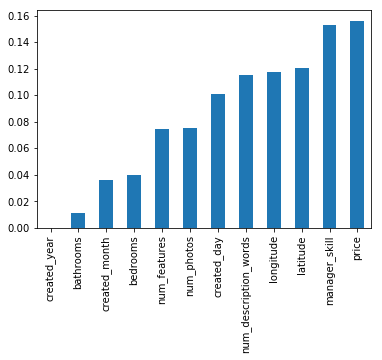

In [80]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### "high_frac", "low_frac" and "medium_frac" are dependent, choose only two of them

In [81]:
# no manager_id, no skill, use fractions
np.random.seed(12345)
these_features = [f for f in features_to_use if f not in ['manager_id','manager_skill','low_frac']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.61259558289777627

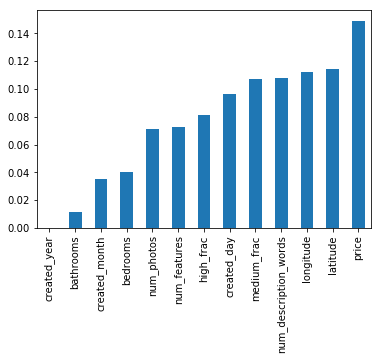

In [82]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

### Oh cool, manager_skill still does boost our performances further and it is almost as important as the price feature.

### Therefore, I suggest you to use this feature in your classifier, no matter its nature. I am confident you gonna get a nice boost if you are not including similar features already in your model.


### Cheers